<a href="https://colab.research.google.com/github/ucalyptus/BS-Nets-Implementation-Pytorch/blob/dual-attention/University_Pavia_BSDA_RecNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras import regularizers
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization, ReLU, PReLU, MaxPool3D, Conv3DTranspose
from keras.layers import Dropout, Input, GlobalAveragePooling2D, multiply, add, Activation, Permute, merge
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.regularizers import l2
from keras import backend as K
import tensorflow as tf
from keras.layers import Layer

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

# from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
# import spectral

# init_notebook_mode(connected=True)
%matplotlib inline
# %tensorflow_version 1.x

In [40]:
!pip install -U spectral
if not (os.path.isfile('/content/PaviaU.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
if not (os.path.isfile('/content/PaviaU_gt.mat')):
  !wget http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

Requirement already up-to-date: spectral in /usr/local/lib/python3.6/dist-packages (0.20)


In [0]:
def loadData():
    
    data = sio.loadmat('PaviaU.mat')['paviaU']
    labels = sio.loadmat('PaviaU_gt.mat')['paviaU_gt']
    
    return data, labels

In [0]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [0]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [0]:
X, y = loadData()

In [45]:
print(X.shape)
print(y.shape)

(610, 340, 103)
(610, 340)


In [46]:
X, y = createImageCubes(X, y, 5)

X.shape, y.shape

((42776, 5, 5, 103), (42776,))

# Model and Training

In [0]:
def BAM():
    model = Sequential()
    model.add(Conv2D(filters=64,
                     input_shape=(5, 5, 103),
                     kernel_size=(3,3),
                     strides=1,
                     padding='valid', name="Conv1"))
    model.add(ReLU(name="ReLU1"))
    model.add(GlobalAveragePooling2D(data_format="channels_first"))
    
    model.add(Dense(128))
    model.add(ReLU(name="ReLU2"))
    model.add(Dense(103, activation="sigmoid"))
  
    return model

In [0]:
def DCAE(weight_decay=0.0005):
    model = Sequential()
    model.add(Conv3D(filters=24,
                     input_shape=(103, 5, 5, 1),
                     kernel_size=(24, 3, 3),
                     strides=(1, 1, 1),
                     kernel_regularizer=regularizers.l2(l=weight_decay),
                     padding='valid', name="Conv1"))  
    model.add(BatchNormalization(name="BN1"))
    model.add(PReLU(name="PReLU1"))

    model.add(Conv3D(filters=48,
                     kernel_size=(24, 3, 3),  
                     strides=(1, 1, 1),
                     kernel_regularizer=regularizers.l2(l=weight_decay),
                     padding='valid', name="Conv2"))  
    model.add(BatchNormalization(name="BN2"))
    model.add(PReLU(name="PReLU2"))

    model.add(MaxPool3D(pool_size=(18, 1, 1),
                        strides=(18, 1, 1), name="Pool1"))

    model.add(Conv3DTranspose(filters=24,
                              kernel_size=(32, 3, 3), #(9,3,3),
                              kernel_regularizer=regularizers.l2(
                                  l=weight_decay),
                              strides=(22, 1, 1), name="Deconv1", padding='valid'))
    model.add(BatchNormalization(name="BN3"))
    model.add(PReLU(name="PReLU3"))
    model.add(Conv3DTranspose(filters=1,
                              kernel_size=(28, 3, 3),
                              kernel_regularizer=regularizers.l2(
                                  l=weight_decay),
                              strides=(1, 1, 1), name="Deconv2", padding='valid'))
    model.add(BatchNormalization(name="BN4"))
    
    return model

In [0]:
def Ensemble():
    input_layer = Input((5, 5, 103))
    band_activations = BAM()(input_layer)
    # band_activations = Reshape((200, 1, 1))(band_activations)
    
    bam_output = multiply([band_activations, input_layer])
    
    bam_output = Reshape((103, 5, 5, 1))(bam_output)
    # da_output = DA()(input_layer)
    # da_output = Permute((3,1,2), input_shape=(11,11,200))(da_output)
    # da_output = Reshape((200, 11, 11, 1))(da_output)
    output = DCAE()(bam_output)
    
    
    return Model(inputs=input_layer, outputs=output)
    

In [89]:
# model = DCAE(weight_decay=0.0005)
model = Ensemble()
model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 5, 5, 103)    0                                            
__________________________________________________________________________________________________
sequential_25 (Sequential)      (None, 103)          73191       input_13[0][0]                   
__________________________________________________________________________________________________
multiply_13 (Multiply)          (None, 5, 5, 103)    0           sequential_25[1][0]              
                                                                 input_13[0][0]                   
__________________________________________________________________________________________________
reshape_13 (Reshape)            (None, 103, 5, 5, 1) 0           multiply_13[0][0]         

In [0]:
def psnr(x_true, x_pred):
    n_samples = x_true.shape[0]
    n_bands = x_true.shape[1]
    PSNR = np.zeros(n_bands)
    MSE = np.zeros(n_bands)
    mask = np.ones(n_bands)
    for k in range(n_bands):
        x_true_k = x_true[:, k].reshape([-1])
        x_pred_k = x_pred[:, k].reshape([-1])
        MSE[k] = 1.0 / n_samples * mean_squared_error(x_true_k, x_pred_k, )
        MAX_k = np.max(x_true_k)
        if MAX_k != 0:
            PSNR[k] = 10 * math.log10(math.pow(MAX_k, 2) / MSE[k])
        else:
            mask[k] = 0

    psnr = PSNR.sum()/mask.sum()
    mse = MSE.mean()
    print('psnr', psnr)
    print('mse', mse)
    
    return psnr, mse

In [0]:
import scipy
from scipy.special import kl_div
def Dskl(Bi,Bj):
  
  
  pk = np.histogramdd(np.ravel(Bi), bins = 256)[0]/Bi.size 
  #pk = list(filter(lambda p: p > 0, pk))
  pk = np.array(pk)

  qk = np.histogramdd(np.ravel(Bj), bins = 256)[0]/Bj.size
  #qk = list(filter(lambda p: p > 0, qk)
  qk = np.array(qk)
  
  
  S = kl_div(pk,qk) + kl_div(qk,pk)
  
  #S = np.sum(pk * np.log2(pk / qk), axis=0) + np.sum(qk * np.log2(qk / pk), axis=0)
  
  return S

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
ENTROPY = np.zeros(103)
import skimage.measure
def topkbands(x_predict, topk):
  for i in range(0,len(ENTROPY)):
    ENTROPY[i]+=skimage.measure.shannon_entropy(x_predict[:,i,:,:])
  
  print('Top k bands with Entropy ->',ENTROPY.argsort()[-topk:][::-1])

In [0]:
def MSD(x_predict, topk):
  top = ENTROPY.argsort()[-topk:][::-1]
  perbatch = list(0 for i in range(0,160))
  for batch_idx in range(0,len(perbatch)):
    for i in range(0,len(top)):
      for j in range(0,i):
        perbatch[batch_idx]+=Dskl(x_predict[:,top[i],:,:],x_predict[:,top[j],:,:])
  perbatch = np.array(perbatch)
  perbatch[perbatch>=1E03]=0
  print('Mean of MSD with Top k bands is \n',np.mean(perbatch)*100)

In [0]:
def plott(ENTROPY):
  fig = plt.figure(figsize=(40,4))
  ax1 = fig.add_subplot(121)
  ax1.plot(ENTROPY)



In [0]:
ENTROPY = np.zeros(103)
import skimage.measure
def output_entropy(x_predict):
  for i in range(0,len(ENTROPY)):
    ENTROPY[i]+=skimage.measure.shannon_entropy(x_predict[:,i,:,:])
  plott(ENTROPY)
  

In [0]:
from keras.callbacks import Callback
from sklearn.metrics import mean_squared_error
import math

class MyLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
      x_predict = model.predict(X)
      x_true = np.asarray(X)
      x_pred_centre = x_predict[:, :, 2, 2]
      x_true_centre = x_true[:, :, 2, 2]
      psnr(x_true_centre, x_pred_centre)
      topkbands(x_predict, 15)
    def on_train_end(self,logs=None):
      x_predict = model.predict(X)
      output_entropy(x_predict)
      #MSD(x_predict, 15)




Epoch 1/50





42776/42776 [==============================] - 28s 643us/step - loss: 2775977.4756
psnr 61.49867625590755
mse 22.162991714449596
Top k bands with Entropy -> [27 31 76 10 43 14 68 39  6 35 80 18 64 22 72]
Epoch 2/50
42776/42776 [==============================] - 9s 221us/step - loss: 2695264.1163
psnr 61.66898614748319
mse 21.315502108019142
Top k bands with Entropy -> [ 10  14  92  80  43  76  96  26  22  47  55  51  88 100   6]
Epoch 3/50
42776/42776 [==============================] - 9s 220us/step - loss: 2618955.9455
psnr 61.84242506120355
mse 20.49564857427378
Top k bands with Entropy -> [ 92  10  47  88  84  14  80  96  22  55  51  26  43 100  76]
Epoch 4/50
42776/42776 [==============================] - 9s 220us/step - loss: 2545016.1601
psnr 61.89642206914457
mse 20.267972855057412
Top k bands with Entropy -> [ 10  92  84  22  14  47  51  88  55  26  96  80  43 100  63]
Epoch 5/50
42776/42776 [==============================] - 9s 220us/step - loss: 2473070.623

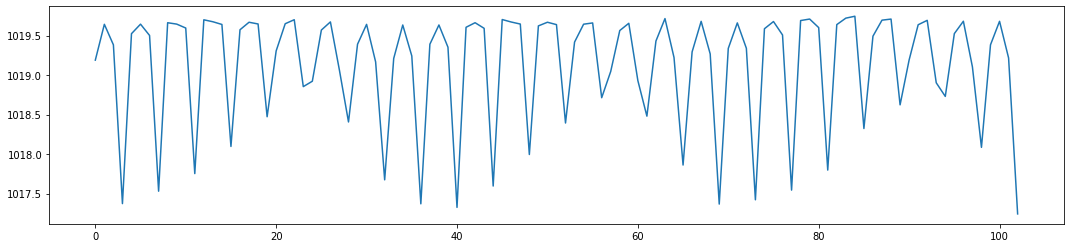

In [98]:
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=0.1))

n_epoch = 50

model.fit(X, X.reshape(-1, 103, 5, 5, 1), epochs=n_epoch, shuffle=True, verbose=1, batch_size=256, callbacks=[MyLogger()])

In [0]:
sel_bands = sorted([ 68, 182,  73, 149,  63, 111, 106, 116, 154, 144,  78,  58, 159, 101, 139])

In [0]:
X, y = loadData()

In [0]:
X_ = X[:, :, sel_bands[0]]
for i in sel_bands[1:]:
  X_ = np.dstack((X_, X[:, :, i]))

In [0]:
X_.shape

In [0]:
img_rows, img_cols = 11, 11
nb_classes = 16
img_channels = 15

In [0]:
import ssrn_SS_IN 

model_res4 = ssrn_SS_IN.ResnetBuilder.build_resnet_8((1, img_rows, img_cols, img_channels), nb_classes)

In [0]:
# ## input layer
# input_layer = Input((5, 5, 30, 1))

# ## convolutional layers
# conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu', padding='same')(input_layer)
# conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu', padding='same')(conv_layer1)
# conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu', padding='same')(conv_layer2)
# print(conv_layer3._keras_shape)
# conv3d_shape = conv_layer3._keras_shape
# conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
# conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

# flatten_layer = Flatten()(conv_layer4)

# ## fully connected layers
# dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
# dense_layer1 = Dropout(0.4)(dense_layer1)
# dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
# dense_layer2 = Dropout(0.4)(dense_layer2)
# output_layer = Dense(units=16, activation='softmax')(dense_layer2)

# model_res4 = Model(inputs=input_layer, outputs=output_layer)

In [0]:
adam = Adam(lr=0.0001, decay=1e-06)
model_res4.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [0]:
X, y = createImageCubes(X_, y, 11)

In [0]:
X.shape, y.shape

In [0]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [0]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, 0.5)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

In [0]:
Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.5)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

In [0]:
Xtrain = Xtrain.reshape(-1, 11, 11, 15, 1)
Xtrain.shape

In [0]:
Xvalid = Xvalid.reshape(-1, 11, 11, 15, 1)
Xvalid.shape

In [0]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

In [0]:
yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [0]:
model_res4.summary()

In [0]:
history = model_res4.fit(x=Xtrain, y=ytrain, batch_size=64, epochs=500, validation_data=(Xvalid, yvalid))

In [0]:
Xtest = Xtest.reshape(-1, 11, 11, 15, 1)
Xtest.shape

In [0]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

In [0]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

Y_pred_test = model_res4.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

In [0]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [0]:
def reports (X_test,y_test):
    #start = time.time()
    Y_pred = model_res4.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)

    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                    ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                    'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                    'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                    'Stone-Steel-Towers']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model_res4.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [0]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))